# PySpice_EyePoint_CurveTracer
## часть проекта по восстановлению электронной схемы характериографом

## https://github.com/vasily84/PySpice_CurveTracer 


### Необходимы - python3.x, sklearn,PySpice

### необходимые библиотеки -
### PySpice - симуляция электронных схем из Python
https://pyspice.fabrice-salvaire.fr/ 

https://github.com/FabriceSalvaire/PySpice

### scikit-learn библиотека машинного обучения
https://scikit-learn.org/stable/index.html

## Как использовать?
### Необходимо задать рабочую папку программы в переменной FILEBASE_ROOT ( ячейка ниже). 
### Варианты запуска программы :

* Первый запуск - Папка задана, но не существует: программа создаст папку и скачает библиотеку spice компонентов из github, затем сгенерирует синтетические данные для схем, описанных в коде и построит модели машинного обучения для них. Для каждой модели создается отдельная папка внутри FILEBASE_ROOT. Туда же пишется её .pickle образ. При последующих запусках модели будут подгружаться с диска.


* Второй и прочие запуски - (папка FILEBASE_ROOT содержит библиотеку spice компонентов и дополнительные папки с обученными моделями) обученные модели загружаются с диска.


* При необходимости переобучить модель - можно удалить файл модели .pickle из ее подпапки или всю её подпапку - при следующем запуске ноутбука модель будет перетренирована.


* При необходимости перенести ноутбук целиком на другой компьютер можно скопировать папку FILEBASE_ROOT и указать правильные пути к ней, но следует помнить о возможной несовместимости .pickle объектов для разных версий питона и библиотек.

### Код написан последовательно сверху вниз-
### для тестирования и исследовательских целей удобнее всего запускать ноутбук целиком Menu->Kernel->Restart & Run All, помещая необходимый дополнительный код в самые нижние ячейки ноутбука, и затем дописывая и запуская ячейки


In [1]:
FILEBASE_ROOT = 'E:\EyePoint' # путь к рабочей папке программы

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import itertools
from sklearn import __version__ as sk_version

import PySpice
import PySpice.Logging.Logging as Logging
from PySpice.Spice.Netlist import Circuit
from PySpice.Spice.Library import SpiceLibrary
from PySpice.Doc.ExampleTools import find_libraries
from PySpice.Unit import *

import os
import uuid
import random
import requests
import zipfile

logger = Logging.setup_logging()
PySpice.show_version()

print('sklearn version '+sk_version)

Circuit_Set = set() # set of all availible curcuits 

PySpice Version 1.4.3
sklearn version 1.0.2


### проверяем пути к рабочей папке, при необходимости подгружаем spice библиотеки компонентов и обученные модели с github

In [3]:
def download_and_unzip(filePath):
    print('downloading started..')
                       
    url = 'https://github.com/vasily84/PySpice_CurveTracer/raw/main/spice_library.zip'
    # Downloading the file by sending the request to the URL
    req = requests.get(url)

    zipName = os.path.join(filePath,'temp.zip')
    print('from '+str(url)+'\ndownloaded '+str(len(req.content))+' bytes')
    
    # Writing the file to the local file system
    with open(zipName,'wb') as output_file:
        output_file.write(req.content)
    print('downloading completed, UnZip started..')
    
    # unzip 
    with zipfile.ZipFile(zipName, 'r') as zip_ref:
        zip_ref.extractall(filePath)
        
    os.remove(zipName)
    print('UnZip completed..')
    
    
# проверяем пути к рабочей папке,
# при необходимости подгружаем spice библиотеки компонентов
# и обученные модели с github
if not os.path.exists(FILEBASE_ROOT):
    os.makedirs(FILEBASE_ROOT)
    download_and_unzip(FILEBASE_ROOT)

print('\nsimulation dataset on:\n'+FILEBASE_ROOT)

libraries_path = os.path.join(FILEBASE_ROOT,'spice_library')
print('\nspice models library on:\n'+libraries_path)
spice_library = SpiceLibrary(libraries_path)
print(spice_library['1N4148'])


simulation dataset on:
E:\EyePoint

spice models library on:
E:\EyePoint\spice_library
E:\EyePoint\spice_library\diode\switching\1N4148.lib


### код CreateCVC базируется на библиотеке MySpice
https://github.com/LukyanovM/MySpice

используем эту библиотеку, ибо она максимально близко имитирует прибор
EyePoint https://eyepoint.physlab.ru/ru/

In [4]:
import math
import numpy

class CurveTracer_Settings():
    """ EyePoint hardware settings struct"""
    def __init__(self,F=10_000,V=3.3,Rcs=0,SNR=40.0,lendata=50,cycle=3):
        self.F = F
        self.V = V
        self.Rcs = Rcs
        self.SNR = SNR
        self.lendata = lendata
        self.cycle = cycle
    
    def to_numpy(self):
        arr = np.array([self.F, self.V, self.Rcs, self.SNR, self.lendata, self.cycle])
        return arr
    
    def from_numpy(self,arr):
        self.F = arr[0]
        self.V = arr[1]
        self.Rcs = arr[2]
        self.SNR = arr[3]
        self.lendata = arr[4]
        self.cycle = arr[5]
    
ct_default_settings = CurveTracer_Settings()

def plot_analysis_IV(analysis,ax=None):
    """ plot I(V) curve for analysis """
    if ax is None:
        plt.grid()
        plt.plot(analysis.input_dummy, analysis.VCurrent)
        plt.title('I(V)')
        plt.xlabel('Напряжение [В]')
        plt.ylabel('Сила тока [А]')
        return
    ax.grid()
    ax.plot(analysis.input_dummy, analysis.VCurrent)
    ax.set_title('I(V)')
    ax.set_xlabel('Напряжение [В]')
    ax.set_ylabel('Сила тока [А]')
    

def CreateCVC(circuit,ct=ct_default_settings):
    cycle = ct.cycle
    lendata = ct.lendata
    period = 1 / ct.F
    rms_voltage = ct.V / math.sqrt(2)
    # добавляем испытательный щуп в схему
    circuit.R('cs', 'input', 'input_dummy', ct.Rcs)
    circuit.AcLine('Current', circuit.gnd, 'input_dummy', rms_voltage=rms_voltage, frequency=ct.F)
    
    simulator = circuit.simulator()
    analysis = simulator.transient(step_time=period / lendata, end_time=period * cycle)
    analysis.input_dummy = analysis.input_dummy[len(analysis.input_dummy)-lendata:len(analysis.input_dummy)]
    analysis.VCurrent = analysis.VCurrent[len(analysis.VCurrent)-lendata:len(analysis.VCurrent)]
# Расчитываем шум независмо для тока и напряжения исходя из среднеквадратичных значений и одинакового SNR
    avg_V_db = 10 * numpy.log10(numpy.mean(numpy.array(analysis.input_dummy, dtype=float) ** 2))
    avg_Vnoise_db = avg_V_db - ct.SNR
    Vnoise = numpy.random.normal(0, numpy.sqrt(10 ** (avg_Vnoise_db / 10)), len(analysis.input_dummy))
    analysis.input_dummy = numpy.array(analysis.input_dummy, dtype=float) + Vnoise
    avg_I_db = 10 * numpy.log10(numpy.mean(numpy.array(analysis.VCurrent, dtype=float) ** 2))
    avg_Inoise_db = avg_I_db - ct.SNR
    Inoise = numpy.random.normal(0, numpy.sqrt(10 ** (avg_Inoise_db / 10)), len(analysis.VCurrent))
    analysis.VCurrent = numpy.array(analysis.VCurrent, dtype=float) + Inoise
    # удаляем испытательный щуп из схемы
    circuit.Rcs.detach()
    circuit.VCurrent.detach()
    return analysis


#### пример использования CreateCVC

2022-02-01 16:20:18,401 - PySpice.Spice.NgSpice.Shared.NgSpiceShared - Shared.WARNING - spinit was not found
2022-02-01 16:20:18,403 - PySpice.Spice.NgSpice.Shared.NgSpiceShared - Shared.ERROR - Note: can't find init file.


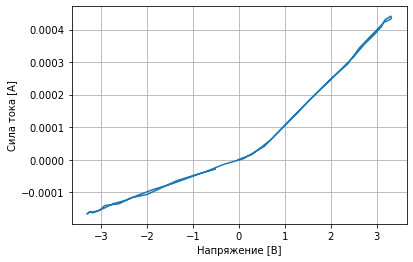

Wall time: 576 ms


In [5]:
%%time
circuit = Circuit('RD')
circuit.include(spice_library['1N4148'])
circuit.R(1,'input',1,10@u_kOhm)
circuit.X('D1', '1N4148', 1, circuit.gnd)
circuit.R(2,'input',circuit.gnd,20@u_kOhm)

analysis = CreateCVC(circuit)
        
plt.grid()
plt.plot(analysis.input_dummy, analysis.VCurrent)
plt.xlabel('Напряжение [В]')
plt.ylabel('Сила тока [А]')
plt.show()



### как построена база?
каждой схеме соответствует папка, в которой хранятся файлы массивов симуляции c номиналами схемы и параметрами прибора,и circuit файл - информация о самой схеме

In [6]:
%%time
def save_cir_analysis(fileName,circuit_params,curve_params,analysis):
    """ save circuit nominals,curve tracer parameters, voltage and current arrays to file"""
    with open(fileName, 'wb') as f:
        np.save(f,circuit_params)
        np.save(f,curve_params)
        np.save(f,analysis.VCurrent)
        np.save(f,analysis.input_dummy)
    
def make_sure_path(path_title):
    """ create path if path not exist, return full path """
    dirName = os.path.join(FILEBASE_ROOT,path_title)
    if not os.path.exists(dirName):
        os.makedirs(dirName)
    return dirName

def save_circuit(dirName,circuit):
    """ save sample circuit on disk """
    fileName = os.path.join(dirName,circuit.title+'.cir')
    with open(fileName,'w') as f:
        f.write(str(circuit))
        

Wall time: 0 ns


In [7]:
def load_circuit_dataset(path_dataset,ct_settings=None,shuffle=True,max_files=None):
    """ load dataset from circuit folder.
    return X,y """
    fileList = [f for f in os.listdir(path_dataset) if f.endswith('.npy')]
    
    if shuffle: 
        random.shuffle(fileList)
        
    if max_files is not None:
        max_files = min(max_files,len(fileList))
        fileList=fileList[0:max_files]
    
    X_data,y_data=[],[]
    
    for fileName in tqdm(fileList): # process files
        with open(os.path.join(path_dataset,fileName), 'rb') as f:
            circuit_params = np.load(f)
            curve_params = np.load(f)
            VCurrent = np.load(f)
            input_dummy = np.load(f)
            
            if ct_settings is not None: 
                ct = CurveTracer_Settings().from_numpy(curve_params)
                F_ok = math.abs(ct_settings.F-ct.F) < 0.1
                V_ok = math.abs(ct_settings.V-ct.V) < 0.05
                if (F_ok and V_ok)==False:
                    continue
                    
                len_ok = ct_settings.lendata == ct.lendata
                cyc_ok = ct_settings.cycle == ct.cycle
                if (len_ok and cyc_ok)==False:
                    continue
                    
                #Rcs_ok = math.abs(ct_settings.Rcs-ct.Rcs) < 1
                #SNR_ok = True #math.abs(ct_settings.SNR-ct.SNR) < 1
        
        # append data to arrays
        y_data.append(circuit_params)
        X_data.append([VCurrent,input_dummy])
        
    return np.array(X_data),np.array(y_data)

## препроцессор данных для моделей -
### делает преобразование фурье, прореживание и прочие манипуляции со входными сигналами

In [8]:
from sklearn.preprocessing import FunctionTransformer,StandardScaler
from scipy.fft import rfft

def my_transform_function(X):
    """ feature engineering on raw analysis signal data.
    Transformations - fft image, input signal resampling etc.""" 
    Xa = []
    for x in X:
        I_signal = x[:len(x)//2] # current      
        #V_signal = x[len(x)//2:] # input voltage - not use
        I_fft = rfft(I_signal)
        x_fft = I_fft[:20] # use only first 20 points on freq domain
        x_abs = np.abs(x_fft)
        x_angle = np.angle(x_fft)
        x_real = np.real(x_fft)
        x_imag = np.imag(x_fft)
        x1 = np.hstack((x,x_abs,x_angle,x_real,x_imag))
        Xa.append(x1)
        
    return np.array(Xa)

MyCustomTransformer = FunctionTransformer(my_transform_function)


## базовый класс схем

In [9]:
import pickle
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor, ExtraTreesRegressor,RandomForestRegressor
from sklearn.multioutput import RegressorChain
from sklearn.pipeline import make_pipeline

class BaseCircuitModel():
    """ base class for circuit models. Provide training, data preprocessing,
    prediction for nominal values """
    def __init__(self,title='baseAbstract',modelDir=None,modelName=None):
        self.title = title
        self.modelDir = os.path.join(FILEBASE_ROOT,self.title) if (modelDir is None) else modelDir  
        make_sure_path(self.modelDir)
        self.modelName = title+'.pickle' if (modelName is None) else modelName   
        self.modelFileName = os.path.join(self.modelDir,self.modelName)
        self.optimize_save_flag = False
        
        try:
            self.load_model()
        except OSError as e:
            print(e)
            print('rebuild model ...')
            self.rebuild_model()
        
    
    def load_model(self):
        with open(self.modelFileName, "rb") as f:
                self.model = pickle.load(f)
                self.rank = self.model.rank # number of circuit variative nominals
    
    def save_model(self):
        with open(self.modelFileName, "wb") as f:
                self.model.rank = self.rank
                pickle.dump(self.model, f)
        
        
    def write_dataset(self,Xvals):
        """ circuit batch simulation over params Xvals"""
        for xval in tqdm(Xvals): # walk over nominals in circuit and create I/V curves
            #print(xval)
            cir_params = np.array(xval)
            circuit = self.build_circuit(cir_params)
            analysis = CreateCVC(circuit)
            fileName = os.path.join(self.modelDir,uuid.uuid4().hex+'.npy')
            save_cir_analysis(fileName,cir_params,ct_default_settings.to_numpy(),analysis)

    def load_dataset(self):
        """ load dataset from disk. Can be overwritten for feature construction"""
        X_data,y_data = load_circuit_dataset(self.modelDir)
        ADim = X_data.shape[0]
        X_data = X_data.reshape(ADim,-1)
        if self.rank==1: # fit shape 1d regression or Nd regression 
            y_data = y_data.reshape(-1)
        else:
            y_data = y_data.reshape(ADim,-1)
            
        return X_data,y_data
        
    def build_model(self,estimator=None, save_model=True, test_model=True ): 
        print('dataset for model '+self.title+' is loading, please wait..')
        
        if estimator is None:
            baseEstimator = GradientBoostingRegressor()
            if self.rank>1:
                self.model = make_pipeline(MyCustomTransformer,RegressorChain(baseEstimator))
            else:
                self.model = make_pipeline(MyCustomTransformer,baseEstimator)
        else:
            self.model = estimator
        
        X_data,y_data = self.load_dataset()  
        print('model '+self.title+' is training, please wait..')
        self.model.fit(X_data,y_data)
        self.model.rank = self.rank
        
        if save_model:
            self.save_model()
            self.load_model()
        
        if test_model:
            print('test_model() routine for '+self.title+' model:')
            self.test_model()
    
    def test_model(self):
        print('!!WARNING : test_model() routine for '+self.title+' model not implemented')
            
    def predict_from_model(self,analysis0):
        """ predict X values for circuit, best fitted to analysis0 """
        X = np.array([analysis0.VCurrent,analysis0.input_dummy]).reshape(-1)
        a = self.model.predict([X])[0]
        return a
        
    def misfit(self,analysis0, Xvals=None):
        """ calculate mse for current from circuit from Xval simulation and from analysis"""
        if Xvals is None:
            Xvals = self.predict_from_model(analysis0)
            
        circuit = self.build_circuit(Xvals)
        analysis1 = CreateCVC(circuit)
        
        return mean_squared_error(analysis1.VCurrent,analysis0.VCurrent)
    
    def _optimize_func(self,Xvals):      
        circuit = self.build_circuit(Xvals)
        analysis1 = CreateCVC(circuit)
        
        if self.optimize_save_flag:
            fileName = os.path.join(self.modelDir,'o_'+uuid.uuid4().hex+'.npy')
            save_cir_analysis(fileName,Xvals,ct_default_settings.to_numpy(),analysis1)

        return mean_squared_error(analysis1.VCurrent,self._analysis0.VCurrent)

    def optimize_from_X(self,analysis0,Xvalues = None):
        if Xvalues is None:
            Xvalues = self.predict_from_model(analysis0).reshape(-1)
        self._analysis0 = analysis0 #
        
        optimize_result = minimize(self._optimize_func,Xvalues)
        
        return (optimize_result.x, optimize_result)
        
    


### Реализация конкретных схем из резисторов, емкостей, индуктивностей и диодов 
## rank 1, rank 2

In [10]:
######################################################################

class R_circuit(BaseCircuitModel):
    def __init__(self):
        super().__init__('R')
            
    def build_circuit(self,Xvals): 
        if isinstance(Xvals, float):
            r1 = Xvals
        elif isinstance(Xvals, list):
            r1 = Xvals[0]
        else: # it is numpy array
            r1 = Xvals.item()
            
        circuit = Circuit('R')
        circuit.R(1,'input',circuit.gnd,r1@u_kOhm)
        return circuit
    
    def rebuild_model(self):
        self.rank = 1
        self.write_dataset(np.linspace(1.,100.))
        self.write_dataset(np.linspace(0.,20.))
        self.write_dataset(np.linspace(50.,500.,10))
        self.build_model()
        
    def test_model(self):
        print('actual r \t predicted r \t acc dr/r ')
        
        for r in np.array([0.1, 1, 1.1, 3., 10., 15., 22., 30., 50., 70., 75., 98., 100.]):
            analysis0 = CreateCVC(self.build_circuit(r))
            x = self.predict_from_model(analysis0)
            acc = np.abs((x-r)/r)
            print(str(r),str(x),str(acc),sep='\t')
            
Circuit_Set.add(R_circuit)
    
######################################################################

class C_circuit(BaseCircuitModel):
    def __init__(self):
        super().__init__('C')
        
    def build_circuit(self,Xvals): 
        if isinstance(Xvals, float):
            c1 = Xvals
        elif isinstance(Xvals, list):
            c1 = Xvals[0]
        else: # it is numpy array
            c1 = Xvals.item()
            
        circuit = Circuit('C')
        circuit.C(1,'input',circuit.gnd,c1@u_uF)
        return circuit
    
    def rebuild_model(self):
        self.rank = 1
        self.write_dataset(np.linspace(0.5,100))
        self.write_dataset(np.linspace(0.001,1.5,100))
        self.build_model()
        
    def test_model(self):
        print('actual c \t predicted c \t acc dc/c ')
        
        for c in np.array([0.1, 1, 1.1, 3., 10., 15., 22., 30., 50., 70., 75., 98., 100.]):
            analysis0 = CreateCVC(self.build_circuit(c))
            x = self.predict_from_model(analysis0)
            acc = np.abs((x-c)/c)
            print(str(c),str(x),str(acc),sep='\t')
    
Circuit_Set.add(C_circuit)
    
######################################################################

class L_circuit(BaseCircuitModel):
    def __init__(self):
        super().__init__('L')
            
    def build_circuit(self,Xvals): 
        if isinstance(Xvals, float):
            l1 = Xvals
        elif isinstance(Xvals, list):
            l1 = Xvals[0]
        else: # it is numpy array
            l1 = Xvals.item()
            
        circuit = Circuit('L')
        circuit.L(1,'input',circuit.gnd,l1@u_uH)
        return circuit
    
    def rebuild_model(self):
        self.rank = 1
        self.write_dataset(np.linspace(0.001,10))
        self.write_dataset(np.linspace(3,100))
        self.write_dataset(np.linspace(50,1000))
        self.build_model()
        
    def test_model(self):
        print('actual c \t predicted c \t acc dc/c ')
        
        for l in np.array([0.1, 1, 1.1, 3., 10., 15., 22., 30., 50., 70., 175., 398., 700.]):
            analysis0 = CreateCVC(self.build_circuit(l))
            x = self.predict_from_model(analysis0)
            acc = np.abs((x-l)/l)
            print(str(l),str(x),str(acc),sep='\t')
        
Circuit_Set.add(L_circuit)
######################################################################

class DR_circuit(BaseCircuitModel):
    def __init__(self):
        super().__init__('DR')
            
    def build_circuit(self,Xvals): 
        if isinstance(Xvals, float):
            r1 = Xvals
        elif isinstance(Xvals, list):
            r1 = Xvals[0]
        else: # it is numpy array
            r1 = Xvals.item()
        
        circuit = Circuit('DR')
        circuit.include(spice_library['1N4148'])
        circuit.X('D1', '1N4148', 'input', circuit.gnd)
        circuit.R(1,'input',circuit.gnd,r1@u_kOhm)
        return circuit
    
    def rebuild_model(self):
        self.rank = 1
        self.write_dataset(np.linspace(1,100))
        self.write_dataset(np.linspace(0,3.))
        self.build_model()
        
    def test_model(self):
        print('actual r \t predicted r \t acc dr/r ')
        
        for r in np.array([0.1, 1, 1.1, 3., 10., 15., 22., 30., 50., 70., 75., 98., 100.]):
            analysis0 = CreateCVC(self.build_circuit(r))
            x = self.predict_from_model(analysis0)
            acc = np.abs((x-r)/r)
            print(str(r),str(x),str(acc),sep='\t')
    
Circuit_Set.add(DR_circuit)
######################################################################

class D_R_circuit(BaseCircuitModel):
    def __init__(self):
        super().__init__('D_R')       
        
    def build_circuit(self,Xvals): 
        if isinstance(Xvals, float):
            r1 = Xvals
        elif isinstance(Xvals, list):
            r1 = Xvals[0]
        else: # it is numpy array
            r1 = Xvals.item()
        
        circuit = Circuit('D_R')
        circuit.include(spice_library['1N4148'])
        circuit.X('D1', '1N4148', 'input', 2)
        circuit.R(1,2,circuit.gnd,r1@u_kOhm)
        return circuit
    
    def rebuild_model(self):
        self.rank = 1
        self.write_dataset(np.linspace(1,100))
        self.write_dataset(np.linspace(0,3.))
        self.build_model()
        
    def test_model(self):
        print('actual r \t predicted r \t acc dr/r ')
        
        for r in np.array([0.1, 1, 1.1, 3., 10., 15., 22., 30., 50., 70., 75., 98., 100.]):
            analysis0 = CreateCVC(self.build_circuit(r))
            x = self.predict_from_model(analysis0)
            acc = np.abs((x-r)/r)
            print(str(r),str(x),str(acc),sep='\t')
    
Circuit_Set.add(D_R_circuit)
###################################################################

class RC_circuit(BaseCircuitModel):
    def __init__(self):
        super().__init__('RC')
        
    def build_circuit(self,Xvals):
        r1,c1 = Xvals[0],Xvals[1]
        
        circuit = Circuit('RC')
        circuit.R(1,'input',circuit.gnd,r1@u_kOhm)
        circuit.C(1,'input',circuit.gnd,c1@u_uF)
        return circuit
        
    def rebuild_model(self):
        self.rank = 2
        self.write_dataset(itertools.product(np.linspace(0,100),np.linspace(1e-2,10)))
        self.write_dataset(itertools.product(np.linspace(1,20),np.linspace(3,30)))
        self.write_dataset(itertools.product(np.linspace(0,4),np.linspace(1e-2,10)))
        self.build_model()
        
    def test_model(self):
        print('real r','real c','r?','c?','real rc','rc?',sep='\t')

        R = [0.1, 2. , 5. , 10. , 70.]
        C = [1., 0.1, 10., 30., 5.]
        for r,c in zip(R,C):
            analysis0 = CreateCVC(self.build_circuit([r,c]))
            rx,cx = self.predict_from_model(analysis0)
            rc = r*c
            rcx = rx*cx
            print(str(r),str(c),str(rx),str(cx),str(rc),str(rcx),sep='\t')
    
Circuit_Set.add(RC_circuit)
###################################################################

class R_C_circuit(BaseCircuitModel):
    def __init__(self):
        super().__init__('R_C')
            
    def build_circuit(self,Xvals):
        r1,c1 = Xvals[0],Xvals[1]
        
        circuit = Circuit('R_C')
        circuit.R(1,'input',2,r1@u_kOhm)
        circuit.C(1,2, circuit.gnd,c1@u_uF)
        return circuit
    
    def rebuild_model(self):
        self.rank = 2
        self.write_dataset(itertools.product(np.linspace(0,100),np.linspace(1e-2,10)))
        self.write_dataset(itertools.product(np.linspace(1,20),np.linspace(3,30)))
        self.write_dataset(itertools.product(np.linspace(0,4),np.linspace(1e-2,10)))
        self.build_model()
        
    def test_model(self):
        print('real r','real c','r?','c?','real rc','rc?',sep='\t')

        R = [0.1, 2. , 5. , 10. , 70.]
        C = [1., 0.1, 10., 30., 5.]
        for r,c in zip(R,C):
            analysis0 = CreateCVC(self.build_circuit([r,c]))
            rx,cx = self.predict_from_model(analysis0)
            rc = r*c
            rcx = rx*cx
            print(str(r),str(c),str(rx),str(cx),str(rc),str(rcx),sep='\t')
    
Circuit_Set.add(R_C_circuit)
###################################################################

class DR_R_circuit(BaseCircuitModel):
    def __init__(self):
        super().__init__('DR_R')
        
    def build_circuit(self,Xvals): 
        r1,r2 = Xvals[0],Xvals[1]
        
        circuit = Circuit('DR_R')
        circuit.include(spice_library['1N4148'])
        circuit.X('D1', '1N4148', 'input', 2)
        circuit.R(1,'input',2,r1@u_kOhm)
        circuit.R(2,2,circuit.gnd,r2@u_kOhm)
        
        return circuit

    
    def rebuild_model(self):
        self.rank = 2
        self.write_dataset(itertools.product(np.linspace(0,100),np.linspace(0,100)))   
        self.write_dataset(itertools.product(np.linspace(0,20),np.linspace(0,20)))     
        self.write_dataset(itertools.product(np.linspace(0,10),np.linspace(0,10)))   
        self.write_dataset(itertools.product(np.linspace(0,1),np.linspace(0,10)))   
        self.write_dataset(itertools.product(np.linspace(0,10),np.linspace(0,1)))   
        self.build_model()
        
    def test_model(self):
        print('real r1','real r2','r1?','r2?',sep='\t')

        R1 = [0.1, 2. , 5. , 10. , 70.]
        R2 = [1., 0.1, 10., 30., 5.]
        for r1,r2 in zip(R1,R2):
            analysis0 = CreateCVC(self.build_circuit([r1,r2]))
            r1x,r2x = self.predict_from_model(analysis0)
            print(str(r1),str(r2),str(r1x),str(r2x),sep='\t')
    
Circuit_Set.add(DR_R_circuit)
    
###################################################################

class DR_DR_circuit(BaseCircuitModel):
    def __init__(self):
        super().__init__('DR_DR')
        
    def build_circuit(self,Xvals): 
        r1,r2 = Xvals[0],Xvals[1]
        
        circuit = Circuit('DR_DR')
        circuit.include(spice_library['1N4148'])
        circuit.X('D1', '1N4148', 'input', 2)
        circuit.R(1,2,circuit.gnd,r1@u_kOhm)
        circuit.X('D2', '1N4148', 3, 'input')
        circuit.R(2,3,circuit.gnd,r2@u_kOhm)
        
        return circuit

    
    def rebuild_model(self):
        self.rank = 2
        self.write_dataset(itertools.product(np.linspace(0,100),np.linspace(0,100)))   
        self.write_dataset(itertools.product(np.linspace(0,20),np.linspace(0,20)))     
        self.write_dataset(itertools.product(np.linspace(0,10),np.linspace(0,10)))    
        self.build_model()
        
    def test_model(self):
        print('r1','r2','r1?','r2?',sep='\t')

        R1 = [0.1, 2. , 5. , 10. , 70.]
        R2 = [1., 0.1, 10., 30., 5.]
        for r1,r2 in zip(R1,R2):
            analysis0 = CreateCVC(self.build_circuit([r1,r2]))
            r1x,r2x = self.predict_from_model(analysis0)
            print(str(r1),str(r2),str(r1x),str(r2x),sep='\t')
    
Circuit_Set.add(DR_DR_circuit)

### Реализация конкретных схем из резисторов, емкостей, индуктивностей и диодов 
## rank 3

In [11]:
###################################################################

class DR_DR_R_circuit(BaseCircuitModel):
    def __init__(self):
        super().__init__('DR_DR_R')
        
    def build_circuit(self,Xvals): 
        r1,r2,r3 = Xvals[0],Xvals[1],Xvals[2]
        
        circuit = Circuit('DR_DR_R')
        circuit.include(spice_library['1N4148'])
        circuit.X('D1', '1N4148', 'input', 2)
        circuit.R(1,2,circuit.gnd,r1@u_kOhm)
        circuit.X('D2', '1N4148', 3, 'input')
        circuit.R(2,3,circuit.gnd,r2@u_kOhm)
        circuit.R(3,'input',circuit.gnd,r3@u_kOhm)
        
        return circuit

    
    def rebuild_model(self):
        self.rank = 3
        self.write_dataset(itertools.product(np.linspace(0,100,20),np.linspace(0,100,20),np.linspace(0,100,20)))   
        self.build_model()
        
    def test_model(self):
        print('r1','r2','r3','r1?','r2?','r3?',sep='\t')

        R1 = [0.1, 2. , 5. , 10. , 70.]
        R2 = [1., 0.1, 10., 30., 5.]
        R3 = [1., 0.1, 10., 30., 5.]
        for r1,r2,r3 in zip(R1,R2,R3):
            analysis0 = CreateCVC(self.build_circuit([r1,r2,r3]))
            r1x,r2x,r3x = self.predict_from_model(analysis0)
            print(str(r1),str(r2),str(r3),str(r1x),str(r2x),str(r3x),sep='\t')
    
Circuit_Set.add(DR_DR_R_circuit)

### тестирование разных схем

In [12]:
EP = R_circuit()
EP.test_model()

EP = R_C_circuit()
EP.test_model()

EP = DR_DR_circuit()
EP.test_model()


actual r 	 predicted r 	 acc dr/r 
0.1	0.6365876751506985	5.365876751506985
1.0	1.009232604013314	0.009232604013313939
1.1	1.5989243622077816	0.453567602007074
3.0	3.720761325676303	0.24025377522543426
10.0	10.12794201717213	0.01279420171721295
15.0	14.562709940028123	0.029152670664791814
22.0	21.160029322096314	0.03818048535925846
30.0	30.008342229619196	0.00027807432063985024
50.0	48.68485307427691	0.02630293851446183
70.0	69.44970556764503	0.007861349033642486
75.0	73.93337908626037	0.01422161218319502
98.0	98.00284011944171	2.8980810629737252e-05
100.0	100.16921251782716	0.001692125178271624
real r	real c	r?	c?	real rc	rc?
0.1	1.0	0.1057016762730555	1.1386802182768647	0.1	0.12036040781083333
2.0	0.1	2.020765987636106	0.17830925603806247	0.2	0.36032127988241464
5.0	10.0	4.949608995964145	14.032808447270597	50.0	69.45691492925219
10.0	30.0	9.926416288786106	14.057937651279415	300.0	139.54494128839949
70.0	5.0	71.4244021155134	4.828594603495659	350.0	344.8794826128719
r1	r2	r1?	r2?
0.

### Класс для предсказания схемы по ВАХ

In [13]:
class CircuitPredictor():
    """ class for circuit prediction from i,v curves using list of various circuit models"""
    def __init__(self):
        # append all availible circuit models to this list 
        self.circuitModels = []
        for cir in Circuit_Set:
            self.circuitModels.append(cir())
    
    
    def predict_from_model(self,analysis0):
        """"""
        m_List = []
        for m in self.circuitModels:
            Xvars = m.predict_from_model(analysis0)
            err = m.misfit(analysis0,Xvars)
            m_List.append((Xvars,m,err))
            
        m_List = sorted(m_List, key = lambda k:k[2])
        best = m_List[0] # best suited model
        return best
    
    def test_me(self):
        """"""
        self.test_rankN(1)
        self.test_rankN(2)
        self.test_rankN(3)
        
    def test_rankN(self,N,runsCount = 100,plot_Ok=10,plot_Fail=30):
        print('RANK'+str(N)+' CIRCUIT TESTING ..')
        CIR_N = []
        for cir in Circuit_Set:
            cN = cir()
            if cN.rank==N:
                CIR_N.append(cN)
                
        count_ok = 0
        count_fail = 0
        
        for _ in range(runsCount): 
            objCir = random.choice(CIR_N)
            
            x = 100*np.random.random(N)
            
            analysis0 = CreateCVC(objCir.build_circuit(x))
            Xvars, objX,_ = self.predict_from_model(analysis0)
            if isinstance(objX,type(objCir)):
                print('success: '+str(x)+' -> '+str(Xvars)+' circuit '+objX.title)
                count_ok += 1
                if plot_Ok>0:
                    plot_Ok -=1
                    analysis1 = CreateCVC(objX.build_circuit(Xvars))
                    print('SUCCESS:')
                    plot_analysis_IV(analysis0)
                    plot_analysis_IV(analysis1)
                    plt.show()
            else:
                print('!!fail:  '+str(x)+' -> '+str(Xvars)+' '+objCir.title+' detected like '+objX.title)
                count_fail += 1
                if plot_Fail>0:
                    plot_Fail -=1
                    analysis1 = CreateCVC(objX.build_circuit(Xvars))
                    print('FAIL:')
                    plot_analysis_IV(analysis0)
                    plot_analysis_IV(analysis1)
                    plt.show()
                
        print('\nSUCCESS: '+str(count_ok)+', FAIL: '+str(count_fail)+' of '+str(count_ok+count_fail)+' tests')
   

### тестирование класса предсказания схем

RANK1 CIRCUIT TESTING ..
success: [36.60065762] -> 37.60565827311307 circuit L
SUCCESS:


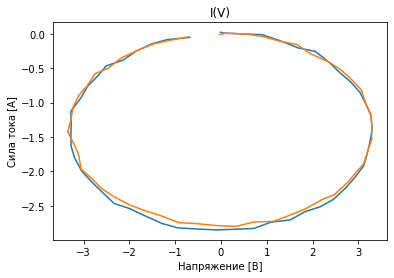

success: [78.05923167] -> 78.04218848909883 circuit D_R
SUCCESS:


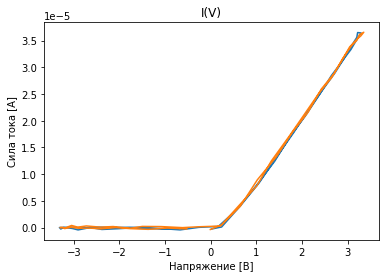

success: [55.804868] -> 54.829538004901366 circuit D_R
SUCCESS:


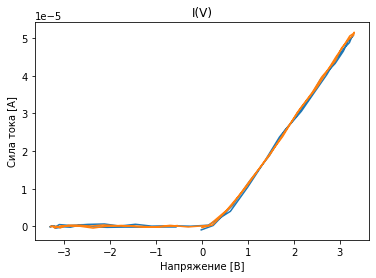

success: [33.68553363] -> 33.608792480495545 circuit D_R
SUCCESS:


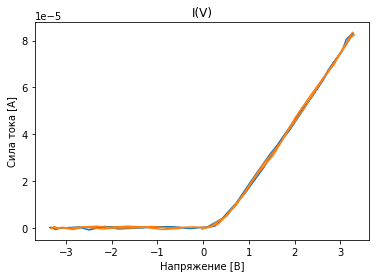

success: [70.3044033] -> 68.23864472311745 circuit D_R
SUCCESS:


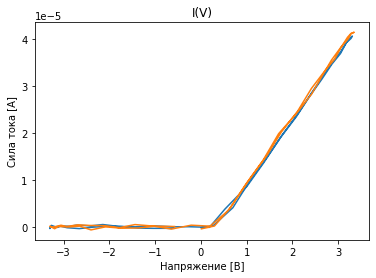

success: [76.8958555] -> 27.23724203955825 circuit DR
SUCCESS:


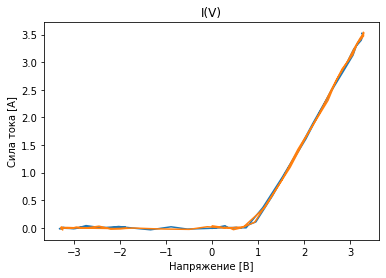

success: [2.12523308] -> 36.31332841428911 circuit DR
SUCCESS:


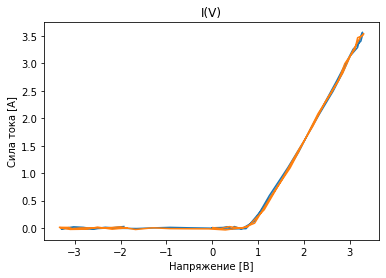

success: [55.29484897] -> 54.845469670610115 circuit R
SUCCESS:


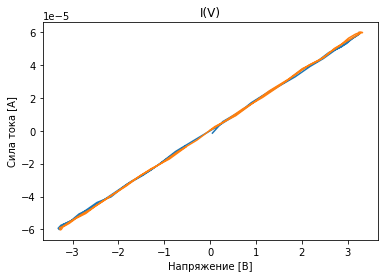

success: [50.08014733] -> 50.55029771337732 circuit L
SUCCESS:


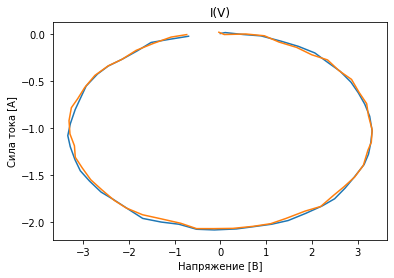

success: [26.44239941] -> 25.12406715809548 circuit L
SUCCESS:


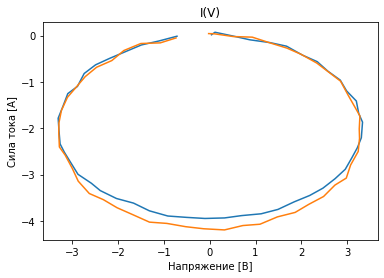

success: [66.5424389] -> 68.80737110601993 circuit C
!!fail:  [19.91003946] -> [ 2.33464259 17.4260433 ] R detected like DR_R
FAIL:


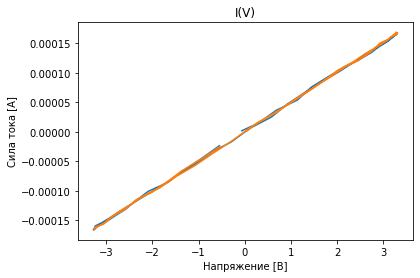

success: [74.43234634] -> 75.76854132710841 circuit D_R
success: [33.57001539] -> 32.984059070068355 circuit C
success: [94.68409472] -> 91.27349484867194 circuit L
success: [45.90034411] -> 19.1127813250131 circuit DR
success: [40.50145455] -> 40.897981555651526 circuit R
success: [66.96296377] -> 62.98543540781136 circuit DR
success: [25.43116631] -> 25.6484887489723 circuit L
success: [96.60763791] -> 95.8691970214256 circuit C
success: [36.08105068] -> 35.7259699720226 circuit R
success: [69.74757621] -> 0.9712167201092007 circuit DR
success: [35.10274387] -> 37.51002868490862 circuit L
success: [36.56643313] -> 36.09227014749759 circuit D_R
success: [63.42229892] -> 64.56664209224896 circuit C
success: [74.05531606] -> 75.78161107798051 circuit D_R
success: [1.25143403] -> -1.6572785819588884 circuit DR
success: [90.1927827] -> 77.46277873449812 circuit DR
success: [76.79589136] -> 34.568750437854646 circuit DR
success: [3.07774673] -> 3.091898987422653 circuit DR
success: [90.184

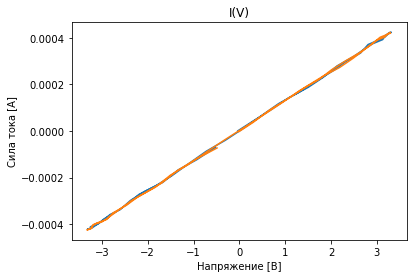

success: [92.0728229] -> 92.073158681117 circuit R
!!fail:  [5.23974094] -> [25.2566839   5.29060867] C detected like RC
FAIL:


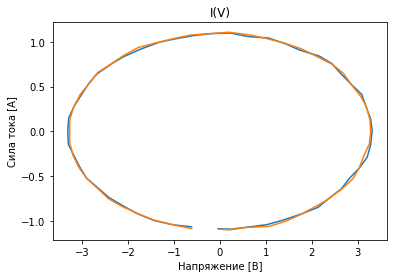

success: [45.4441899] -> 15.557222463246815 circuit DR
success: [78.37104582] -> 79.24779442704647 circuit L
success: [36.31082895] -> 34.5000686808225 circuit D_R
success: [78.35894248] -> 6.873882410186967 circuit DR
success: [52.1282194] -> 16.047496766432342 circuit DR
success: [85.71116614] -> 84.39351128195479 circuit C
success: [54.15676638] -> 55.116807835078994 circuit L
success: [38.37652724] -> 38.03319818850435 circuit L
success: [58.07776564] -> 58.355352152596765 circuit R
!!fail:  [75.12830182] -> [75.50104439  5.02629195] R detected like R_C
FAIL:


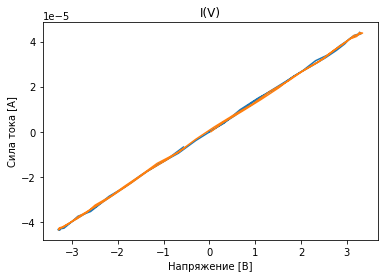

success: [70.77656193] -> 26.144033084742443 circuit DR
success: [69.68487732] -> 69.93579549041783 circuit L
success: [89.19135733] -> 3.453050769074334 circuit DR
!!fail:  [7.56837018] -> [22.79399551  7.75538723] C detected like RC
FAIL:


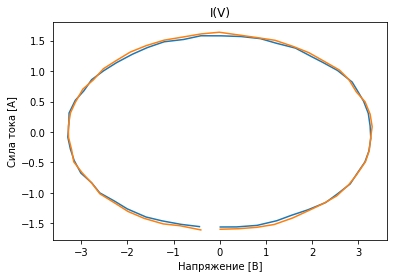

success: [56.67602544] -> 57.38262352391641 circuit R
success: [96.94373244] -> 96.89621571135758 circuit D_R
success: [11.61937436] -> 29.742460650697534 circuit DR
success: [6.45149361] -> 28.04563928315545 circuit DR
success: [31.65878588] -> 30.9958479864343 circuit D_R
!!fail:  [5.71106359] -> [ 5.72426478 15.41231706] R detected like R_C
FAIL:


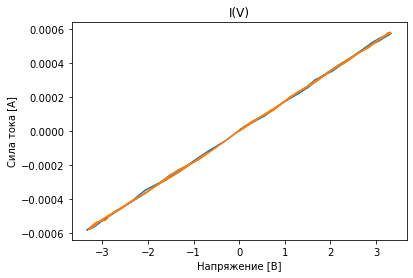

success: [2.88342578] -> 2.890052311210593 circuit D_R
success: [99.65728865] -> 99.51488001328515 circuit L
!!fail:  [28.00857103] -> [ 8.80530059 27.76106893] C detected like RC
FAIL:


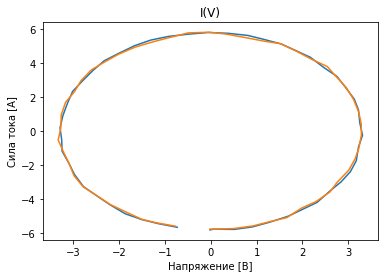

success: [82.91751159] -> 82.0429782619552 circuit C
!!fail:  [77.24992721] -> [77.53171034  5.26087006] R detected like R_C
FAIL:


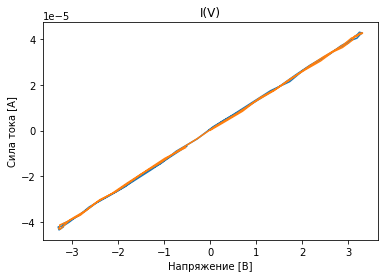

!!fail:  [1.69590417] -> [30.81120071  1.65051101] C detected like RC
FAIL:


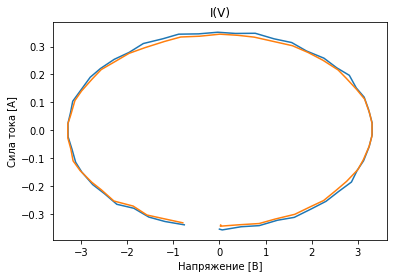

!!fail:  [50.14092913] -> [ 8.77568567 43.80144502] R detected like DR_R
FAIL:


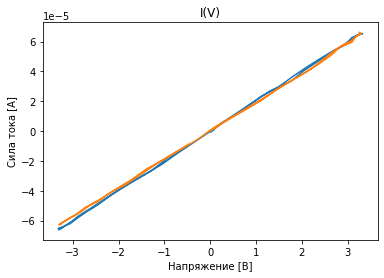

success: [42.64459308] -> 42.028864025302575 circuit D_R
success: [27.12673876] -> 19.99247059759759 circuit DR
success: [65.85969642] -> 67.36262539373253 circuit C
success: [20.83950936] -> 21.205482615612876 circuit D_R
success: [85.36063458] -> 87.04175017832027 circuit D_R
success: [16.58714553] -> 17.14024599117527 circuit D_R
!!fail:  [22.72160094] -> [ 3.31433783 20.00740305] R detected like DR_R
FAIL:


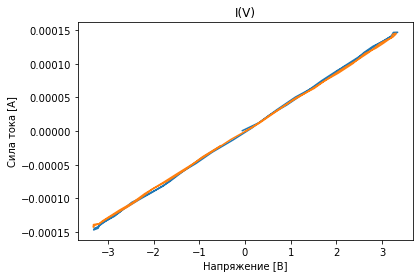

success: [44.68992499] -> 46.783394565509774 circuit C
success: [49.76657664] -> 48.48699246647176 circuit C
success: [94.61880262] -> 91.56591791845003 circuit L
success: [56.65756622] -> 57.14733943610181 circuit C
success: [72.52714847] -> 73.11497199478106 circuit R
success: [91.25197194] -> 90.842323427823 circuit L
success: [73.79548985] -> 46.91222162566728 circuit DR
success: [87.2905315] -> 85.88696026278768 circuit L
success: [60.42023676] -> 61.51607389570506 circuit D_R
success: [24.44982568] -> 26.754306909314927 circuit D_R
success: [65.98102066] -> 36.53669142015594 circuit DR
success: [87.95959291] -> 88.41486522953308 circuit R
success: [78.14994388] -> 78.62273100881383 circuit L
success: [0.34914054] -> 0.35524311387137475 circuit C
success: [98.24769313] -> 55.952058165399066 circuit DR
success: [55.53634639] -> 53.12872544338339 circuit D_R
success: [15.51304841] -> 11.11822256335554 circuit DR
success: [13.20484695] -> 13.867493118658842 circuit L
success: [79.077

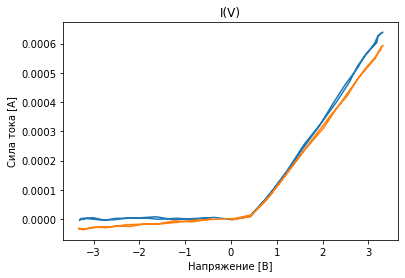

success: [39.06347852] -> 7.48343620694241 circuit DR
!!fail:  [10.8468305] -> [14.26319077 10.87581959] C detected like RC
FAIL:


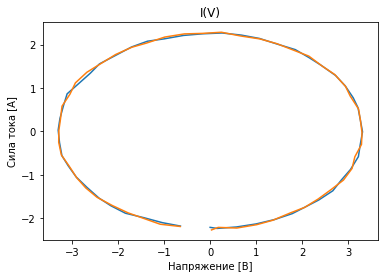

!!fail:  [9.65827402] -> [24.15531914  9.58426697] C detected like RC
FAIL:


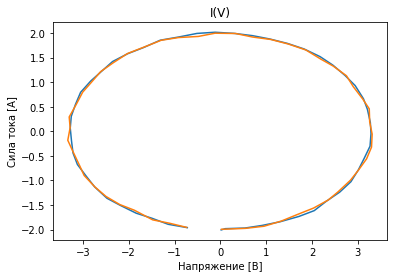

success: [65.98629301] -> 33.01317303488612 circuit DR

SUCCESS: 86, FAIL: 14 of 100 tests
RANK2 CIRCUIT TESTING ..
!!fail:  [76.63211066 62.64678681] -> 63.87490558852857 RC detected like C
FAIL:


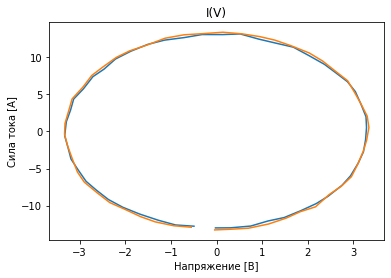

success: [24.39265577 89.94828928] -> [24.78162944 93.72885674] circuit DR_DR
SUCCESS:


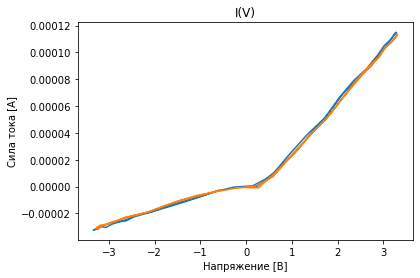

success: [64.39684937 46.81311993] -> [65.30398292  5.19057538] circuit R_C
SUCCESS:


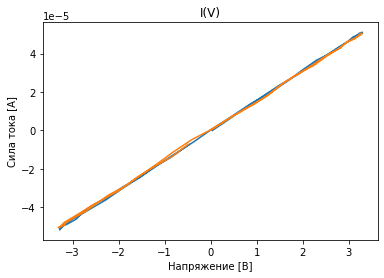

success: [52.00166579  3.9689635 ] -> [52.34854959  4.19381203] circuit DR_DR
SUCCESS:


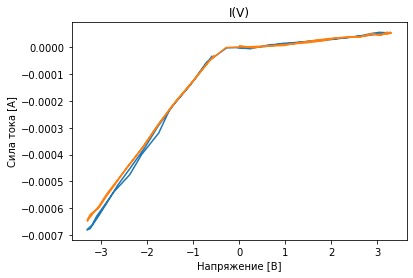

success: [ 3.95789385 64.08492735] -> [4.07100077 9.61077287] circuit R_C
SUCCESS:


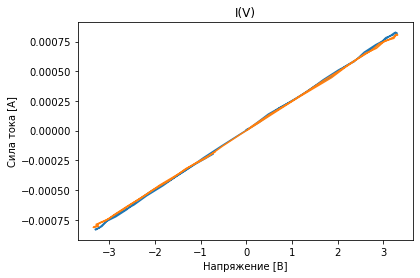

!!fail:  [39.69051907 69.97151277] -> 69.6997582450505 RC detected like C
FAIL:


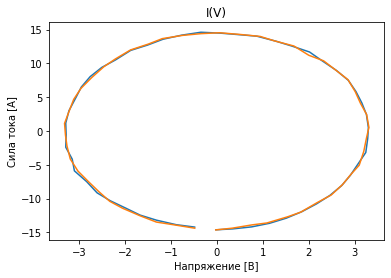

success: [56.70735204 49.74590373] -> [57.14010977  5.70143407] circuit R_C
SUCCESS:


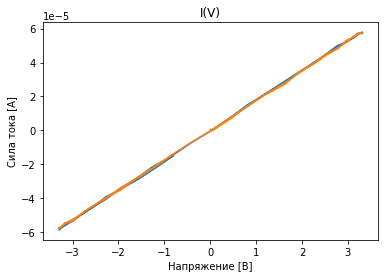

success: [98.15925631 38.02162094] -> [97.94835273  5.86977469] circuit R_C
SUCCESS:


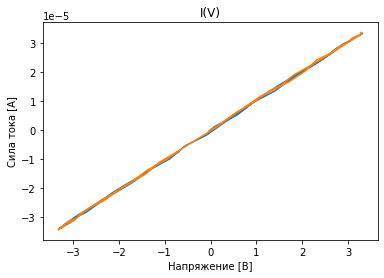

!!fail:  [10.00099917 87.99369134] -> [86.13743928  9.88737533] DR_DR detected like DR_R
FAIL:


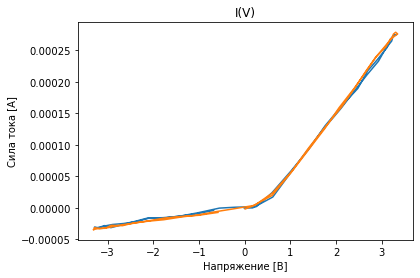

success: [51.70561586 23.26866604] -> [51.01801383  5.70371897] circuit R_C
SUCCESS:


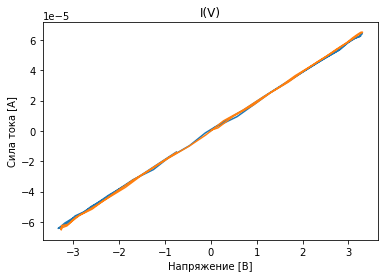

success: [87.8990954  30.16239311] -> [88.00555483 30.48499536] circuit DR_R
SUCCESS:


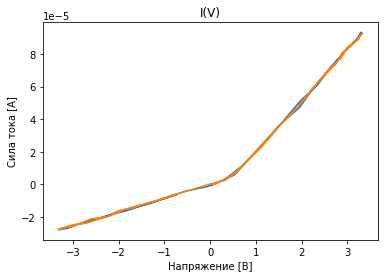

!!fail:  [10.01495685 70.78163297] -> 67.23784839228026 RC detected like C
FAIL:


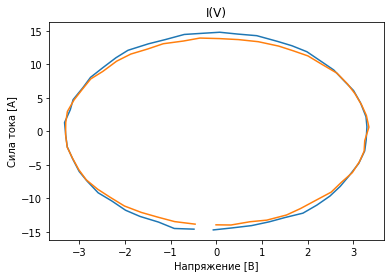

success: [27.09205929 49.18152685] -> [26.51510914  5.59235731] circuit R_C
SUCCESS:


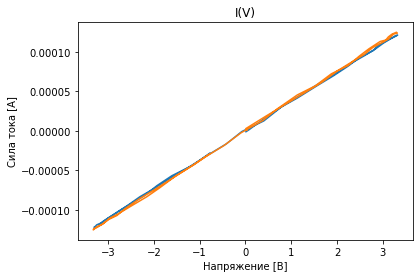

success: [19.43593027 51.1392995 ] -> [15.27181736 50.4647335 ] circuit DR_R
SUCCESS:


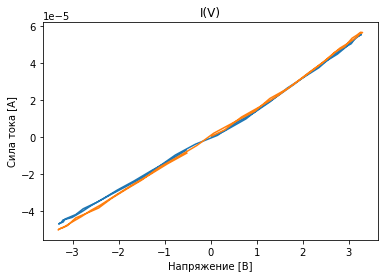

success: [35.43923366 35.48499534] -> [35.5613852   5.00421072] circuit R_C
success: [28.64167775 24.63757306] -> [13.09838788 24.46230268] circuit RC
success: [15.05667574 75.07544102] -> [15.37033519 76.8590583 ] circuit DR_DR
success: [56.54176766  4.39351801] -> [57.77329896  4.42464541] circuit DR_DR
success: [84.66993033 67.98940866] -> [83.65676358 68.82063142] circuit DR_R
success: [31.4378164  90.81894089] -> [31.42165616 89.12194043] circuit DR_R
success: [16.0104437  95.11171162] -> [15.28950525 96.65382842] circuit DR_R
success: [60.16196974  3.37487279] -> [23.71797919  3.51057244] circuit RC
success: [36.77175543  7.85884359] -> [11.85220951  7.77960472] circuit RC
success: [29.04791017 48.27713073] -> [29.16682538  5.08748581] circuit R_C
success: [59.23634163 11.56572597] -> [59.1492071   5.03155932] circuit R_C
success: [76.15853573 29.15407684] -> [79.29872364 29.52907107] circuit DR_R
success: [34.60325875 57.3071885 ] -> [34.15189787 57.24298113] circuit DR_DR
succe

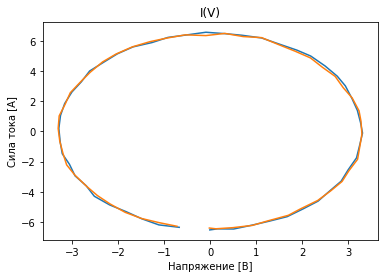

success: [66.79990436 22.51259926] -> [67.84040858 22.91199686] circuit DR_R
success: [20.34734475  9.94541692] -> [35.40262748 10.02869283] circuit RC
success: [16.94336802 18.02909775] -> [17.15299332 18.04967278] circuit DR_DR
success: [25.44278429 54.46446852] -> [26.51158037  5.67903916] circuit R_C
success: [16.18373454  0.84431997] -> [15.60527929  0.99493592] circuit DR_DR
success: [88.43420238 11.32904074] -> [87.76641333  4.98951796] circuit R_C
!!fail:  [48.72510746 52.81839829] -> [52.45080477 86.48274911] DR_R detected like DR_DR
FAIL:


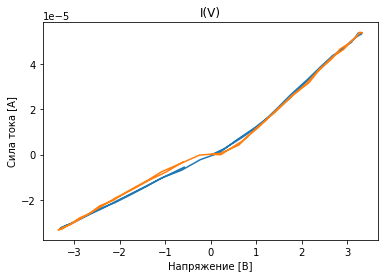

success: [40.78871471 65.47767752] -> [40.7442632  65.35847843] circuit DR_DR
!!fail:  [65.85455976 83.15902   ] -> 82.95604155307554 RC detected like C
FAIL:


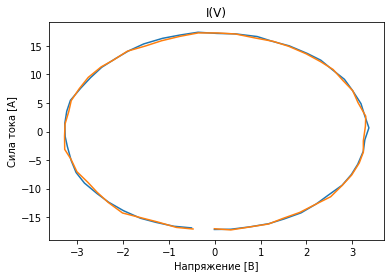

success: [49.12869564  8.5495602 ] -> [48.00437671  8.65490637] circuit DR_DR
success: [47.34182704 49.23037475] -> [46.52149894 48.9680942 ] circuit DR_DR
success: [86.22682744 21.86743032] -> [86.33112253 21.44122682] circuit DR_DR
success: [99.24674504 43.94247848] -> [96.51577345 44.44324201] circuit DR_DR
success: [54.46101109 15.09231047] -> [54.01887904 14.88782275] circuit DR_DR
success: [65.34233878 67.70542204] -> [65.30398292  5.03155932] circuit R_C
success: [75.86668224  7.09917282] -> [75.51142557  4.92262313] circuit R_C
success: [72.95557398 25.76052099] -> [10.5033976  25.57094697] circuit RC
success: [79.30645259 56.72505008] -> [79.60597947  4.91694666] circuit R_C
success: [20.02697823 23.96470583] -> [10.67872848 23.93246045] circuit RC
success: [71.7079759  16.74230425] -> [70.26116242 16.68253129] circuit DR_R
success: [75.46804225  2.21535472] -> [75.51005881  5.03155932] circuit R_C
success: [74.19092969  8.86204997] -> [24.41380609  8.81895437] circuit RC
!!fa

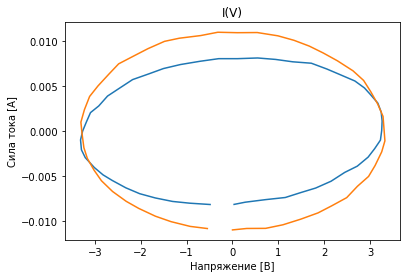

!!fail:  [40.17555381 72.16045911] -> [ 4.95716096 35.70684497] R_C detected like DR_R
FAIL:


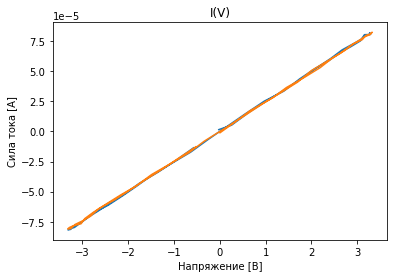

success: [29.46375257 18.08848452] -> [29.20501108  5.17572098] circuit R_C
success: [94.32730555 99.97577603] -> [96.08473631 97.18562368] circuit DR_DR
success: [56.97588741 36.08679745] -> [63.53999032 37.17805781] circuit DR_R
success: [73.01064276 81.61412892] -> [73.21917098 82.08502498] circuit DR_DR
success: [86.04679434 18.01099791] -> [12.53995735 17.88036115] circuit RC
success: [67.96892247 11.69189239] -> [66.13406821 11.47947272] circuit DR_DR
!!fail:  [ 8.4859938  64.43343086] -> 67.99704808408458 RC detected like C
FAIL:


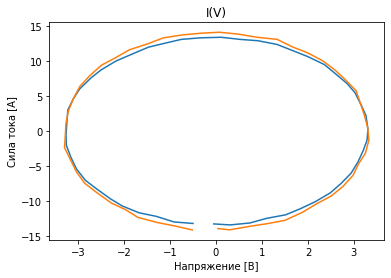

success: [27.22058696 96.36704982] -> [26.5136367   4.99915521] circuit R_C
success: [76.55588706 18.65561924] -> [76.83615532 18.37502701] circuit DR_DR
success: [11.67332431 42.30284503] -> [12.03504617 13.88972859] circuit R_C
!!fail:  [60.59792655 98.65586537] -> 97.54948998628414 RC detected like C
FAIL:


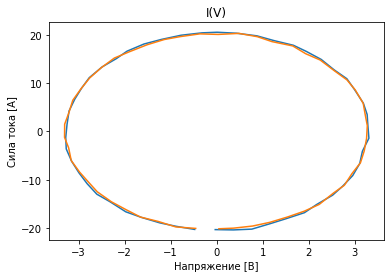

success: [50.41445753 30.71460925] -> [48.20654555 30.41631821] circuit DR_R
success: [88.0693678 78.3491363] -> [88.74657658 78.20029377] circuit DR_DR
success: [70.96577972 60.87631052] -> [71.42458256  5.11979449] circuit R_C
!!fail:  [79.17618954 47.21243712] -> 48.8791313976518 RC detected like C
FAIL:


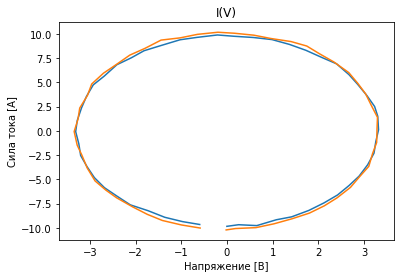

success: [37.3017548   6.55217156] -> [38.41574499  6.38201866] circuit DR_DR
!!fail:  [16.54133325 55.84849424] -> 56.441059101086154 RC detected like C
FAIL:


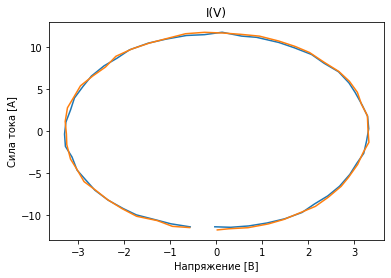

success: [63.55972573 58.66908532] -> [63.34226952  4.710036  ] circuit R_C
!!fail:  [ 1.23799769 16.32301911] -> [16.8195359   1.23568581] DR_DR detected like DR_R
FAIL:


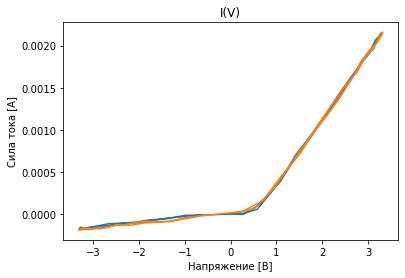

success: [44.61346506 18.72729656] -> [44.89274042  5.15885389] circuit R_C
success: [42.81572054  2.08167293] -> [42.8631511   4.42462947] circuit R_C
success: [18.71798753 61.30072307] -> [18.7137484  14.49701673] circuit R_C
!!fail:  [ 0.91573223 18.5524243 ] -> [21.03285123  0.92769157] DR_DR detected like DR_R
FAIL:


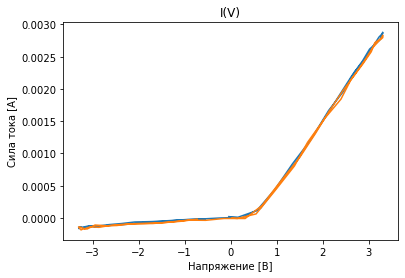

success: [67.63512951  3.11750085] -> [64.80762223  3.39005916] circuit DR_DR
success: [55.83029071  3.50519883] -> [21.53970024  3.51242136] circuit RC
success: [43.04642759 29.21498801] -> [42.86267636  5.11144103] circuit R_C
!!fail:  [76.09086002 33.95557002] -> 34.14202116932366 RC detected like C
FAIL:


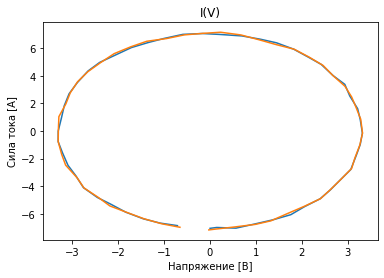

!!fail:  [ 1.51609982 26.3105471 ] -> [27.16440946  1.59319282] DR_DR detected like DR_R
FAIL:


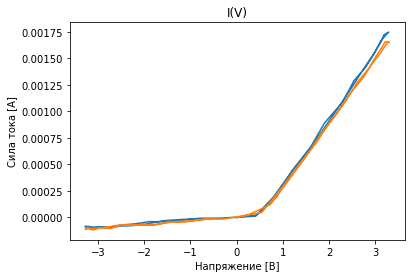

success: [53.69440929 13.71258262] -> [52.45080477 13.2200935 ] circuit DR_DR
success: [38.4642555  12.83463618] -> [35.66737606 12.62569467] circuit DR_R
success: [77.2910598  57.71203232] -> [69.33127242 58.38778805] circuit DR_R
success: [97.42611455 53.78690656] -> [96.51577345 52.7254097 ] circuit DR_DR
success: [62.00676208 90.82635612] -> [63.60349125 88.73832347] circuit DR_R
success: [50.54163084 13.82569949] -> [51.01737707  5.56488458] circuit R_C
success: [24.63814949 33.11463736] -> [20.23546722 32.58205429] circuit DR_R
!!fail:  [52.37048153 30.75459033] -> 30.974744741040176 RC detected like C
FAIL:


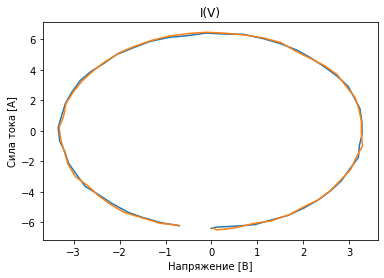

!!fail:  [78.40258599 52.65078411] -> 51.10262835421663 RC detected like C
FAIL:


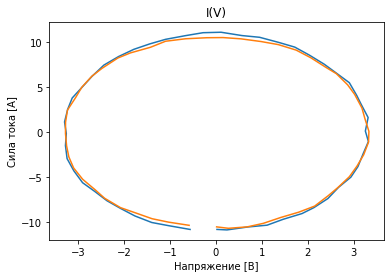

!!fail:  [78.90390994 67.40844329] -> 69.05986220128776 RC detected like C
FAIL:


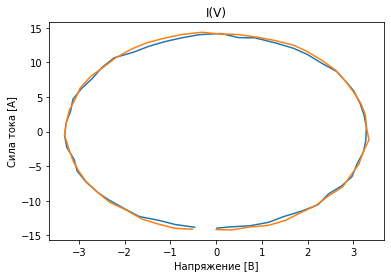

success: [79.03297265 46.90187842] -> [77.28106093 46.73921115] circuit DR_DR
success: [68.8118742  55.08209821] -> [71.02927    55.14669783] circuit DR_R
success: [87.60143301 14.16087148] -> [88.80848836 14.47001082] circuit DR_DR
success: [25.88118015  3.20316191] -> [26.7735886   3.22488855] circuit RC
success: [71.3870116   7.74322111] -> [71.4250573   4.98951796] circuit R_C
!!fail:  [ 6.17083608 78.44467901] -> 80.50405263489546 RC detected like C
FAIL:


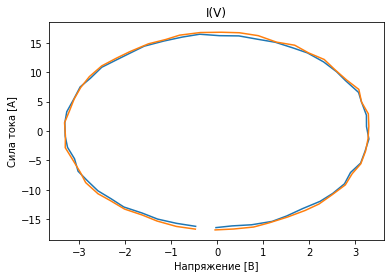

success: [22.66578857 88.47182006] -> [22.44541948  5.03093254] circuit R_C
success: [53.67174397 22.71074799] -> [ 9.47912267 22.81126493] circuit RC

SUCCESS: 79, FAIL: 21 of 100 tests
RANK3 CIRCUIT TESTING ..
!!fail:  [11.98192276 53.48057069 92.02246266] -> [10.18530527 31.66857249] DR_DR_R detected like DR_DR
FAIL:


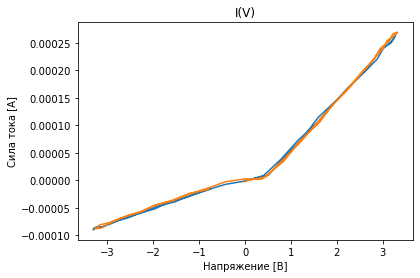

!!fail:  [ 5.84221262 25.12986307 23.52684555] -> [9.73243084 4.54741908] DR_DR_R detected like DR_R
FAIL:


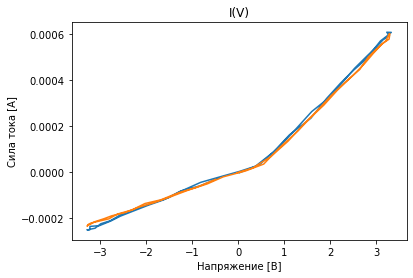

!!fail:  [28.73933209 32.39791808 60.73735661] -> [22.92387112  0.44400761] DR_DR_R detected like R_C
FAIL:


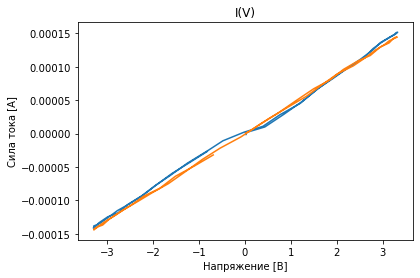

!!fail:  [ 2.17222581 52.1671431  47.54330708] -> [22.64389716  2.00726305] DR_DR_R detected like DR_R
FAIL:


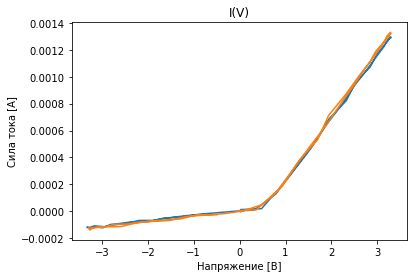

!!fail:  [80.21879509 11.30582148 44.81815141] -> [25.99533371  8.59727688] DR_DR_R detected like DR_DR
FAIL:


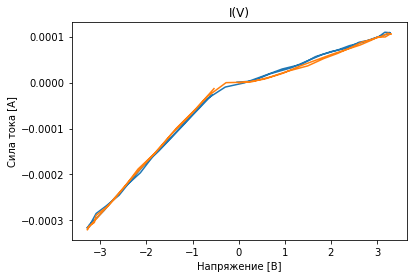

success: [42.91938959 34.16068112 85.124978  ] -> [49.33637172 35.71765739 73.67522704] circuit DR_DR_R
SUCCESS:


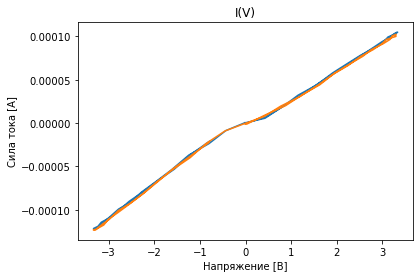

!!fail:  [20.35388319 75.79228163 14.20591856] -> [7.02946309 9.75225951] DR_DR_R detected like DR_DR
FAIL:


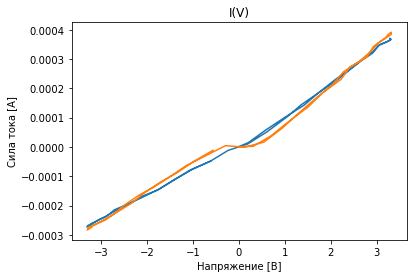

success: [26.76595235 34.75382178 40.40632062] -> [26.57863253 41.84038554 39.39038717] circuit DR_DR_R
SUCCESS:


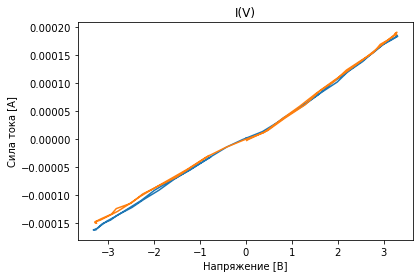

success: [27.74067831 99.45324711 60.29746184] -> [29.73200266 93.9307641  65.39965047] circuit DR_DR_R
SUCCESS:


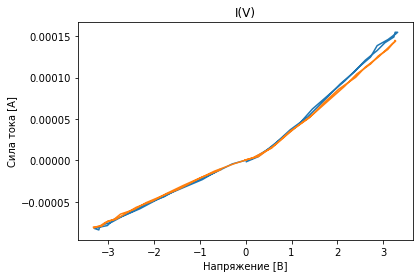

success: [62.25269471 95.56701107 45.86302374] -> [63.30895926 94.33634236 45.79592637] circuit DR_DR_R
SUCCESS:


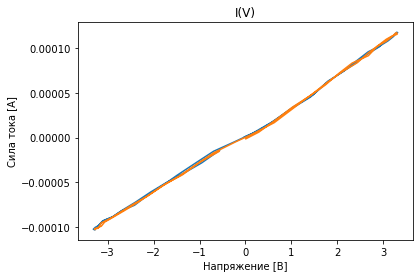

success: [38.59424512 53.15208284 39.28212045] -> [38.49258623 51.53566566 41.99627748] circuit DR_DR_R
SUCCESS:


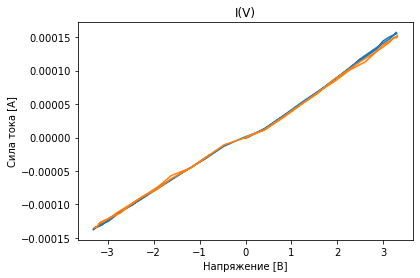

success: [94.68203095 22.14848995 58.75930955] -> [80.0828003  21.95427217 67.9501831 ] circuit DR_DR_R
SUCCESS:


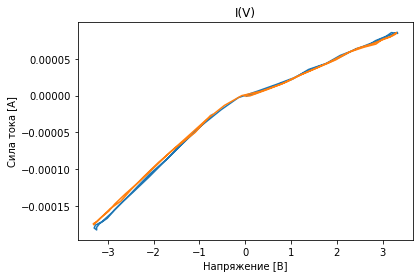

success: [72.26087057 74.63015023 74.07493158] -> [75.55046433 74.24335266 76.23469415] circuit DR_DR_R
SUCCESS:


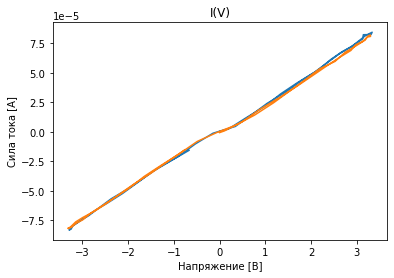

success: [60.81350503 21.8676473  81.28300671] -> [57.64634188 23.00273946 77.91364475] circuit DR_DR_R
SUCCESS:


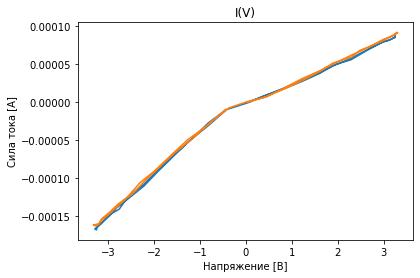

success: [53.38110274 17.12464924 14.01101621] -> [52.56511991 17.73767128 12.52107226] circuit DR_DR_R
SUCCESS:


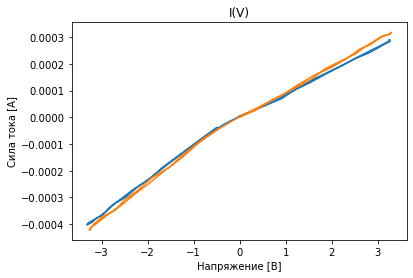

!!fail:  [ 1.19041395 46.41109455 53.11346456] -> [18.69419848  1.1598258 ] DR_DR_R detected like DR_R
FAIL:


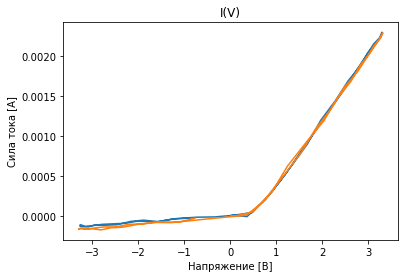

!!fail:  [ 7.71175576 19.42685602 37.56927971] -> [11.07009391  6.14592404] DR_DR_R detected like DR_R
FAIL:


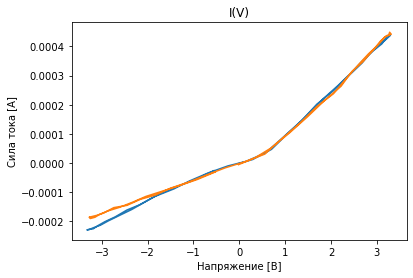

!!fail:  [54.1802499  24.81134784 95.05693531] -> [32.62081183 18.51878607] DR_DR_R detected like DR_DR
FAIL:


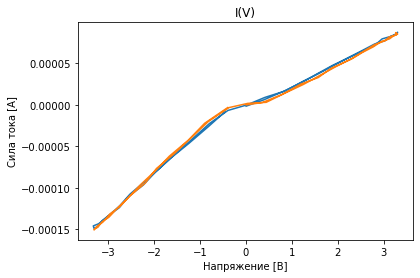

!!fail:  [42.55873075 84.13778838 19.78364764] -> 15.227664793667945 DR_DR_R detected like R
FAIL:


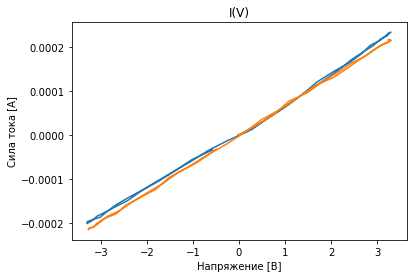

!!fail:  [ 7.03122985 18.06792468 13.64097887] -> [4.19521943 6.78464694] DR_DR_R detected like DR_DR
FAIL:


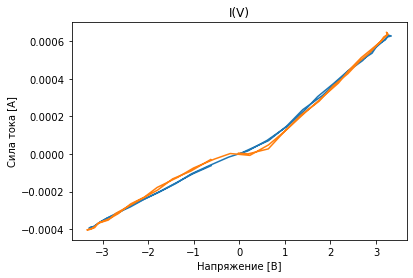

success: [78.09378064 63.5840119  53.33108564] -> [76.87967798 62.32316748 54.91823577] circuit DR_DR_R
SUCCESS:


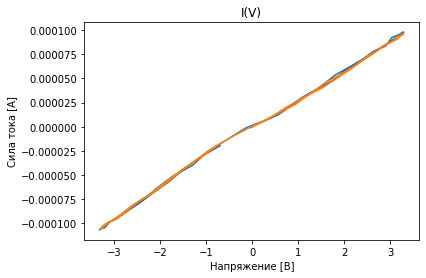

!!fail:  [63.45648475 71.75204922  5.41407103] -> [ 5.08004323 13.04384783] DR_DR_R detected like R_C
FAIL:


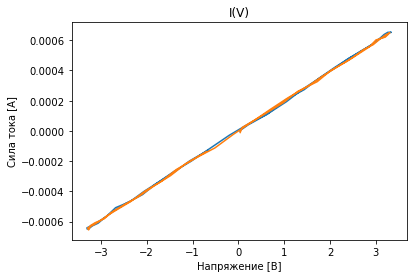

!!fail:  [98.81258753 23.81553642 41.46970902] -> [25.99533371 13.84896839] DR_DR_R detected like DR_DR
FAIL:


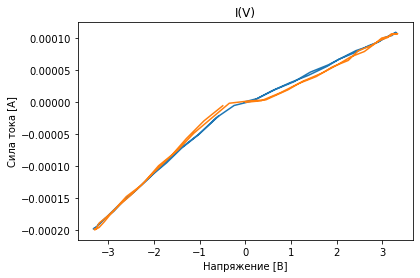

success: [87.14626226 21.59944383 62.07191057] -> [79.79681604 20.70816505 69.6239925 ] circuit DR_DR_R
!!fail:  [99.70171505  6.10886992  8.80226382] -> [6.46741695 3.32355852] DR_DR_R detected like DR_DR
FAIL:


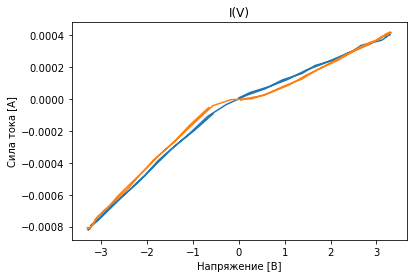

success: [ 4.76963161 85.01678925 90.73375308] -> [ 4.7596727  82.01986134 77.00503467] circuit DR_DR_R
!!fail:  [10.12124794 94.48186072 81.60331381] -> [41.51216486  8.89570961] DR_DR_R detected like DR_R
FAIL:


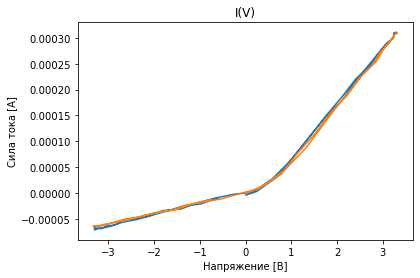

!!fail:  [46.62066035 45.50546646  5.57179212] -> 5.196966734116983 DR_DR_R detected like R
FAIL:


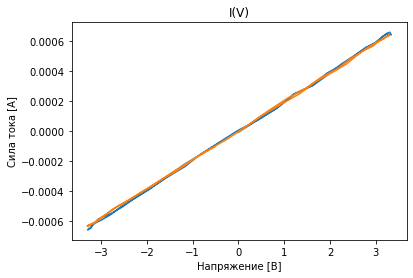

!!fail:  [68.60822607 88.72855261 38.26668545] -> [ 6.67230566 22.32716689] DR_DR_R detected like DR_R
FAIL:


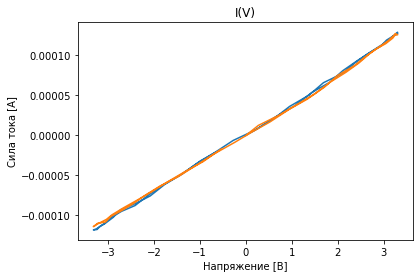

!!fail:  [23.92798385 35.32537933 10.28516518] -> [7.8481632 4.7444783] DR_DR_R detected like R_C
FAIL:


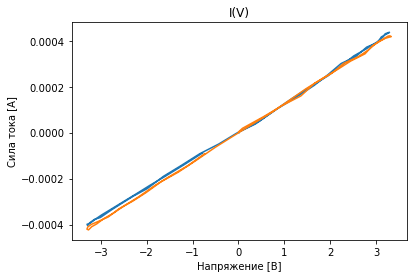

success: [41.43491703 58.23632193 54.16785145] -> [41.55700039 56.89796695 58.72791918] circuit DR_DR_R
!!fail:  [14.82445558 10.75083257 33.82600801] -> [9.57737704 7.71785904] DR_DR_R detected like DR_DR
FAIL:


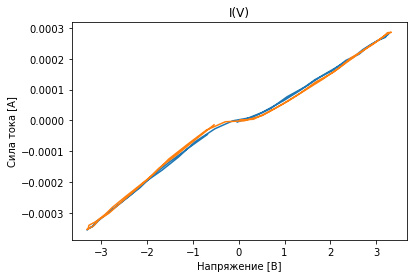

!!fail:  [ 8.81537345 22.47651285 18.99550435] -> [5.41102226 8.96603949] DR_DR_R detected like DR_DR
FAIL:


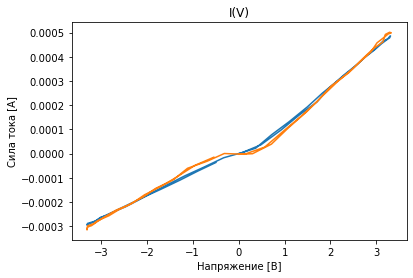

success: [36.76589704 58.52021545 32.53680881] -> [30.58696182 51.75719832 39.66147557] circuit DR_DR_R
!!fail:  [ 9.48189399 91.45988157 13.12905188] -> [8.7840819  4.73763655] DR_DR_R detected like DR_R
FAIL:


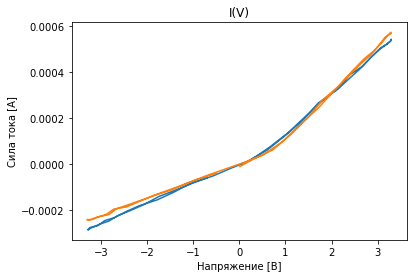

success: [70.9811095  81.34135565 80.13946495] -> [73.97500699 88.5123355  77.31572352] circuit DR_DR_R
!!fail:  [60.48551769 17.64310439 51.48182949] -> [25.99533371 12.28331819] DR_DR_R detected like DR_DR
FAIL:


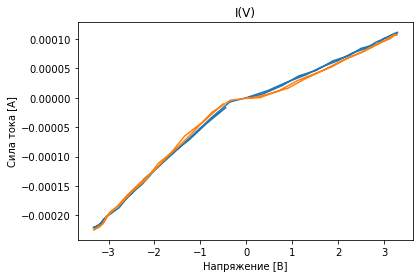

success: [80.63638857 70.66504291 66.57170874] -> [85.24040797 73.49465759 68.48454635] circuit DR_DR_R
success: [74.57752652 36.94233594 18.7958574 ] -> [78.71385154 38.52353086 18.80308019] circuit DR_DR_R
!!fail:  [ 0.45483595 58.83746203 71.32392603] -> [31.71333007  0.46531454] DR_DR_R detected like DR_R
FAIL:


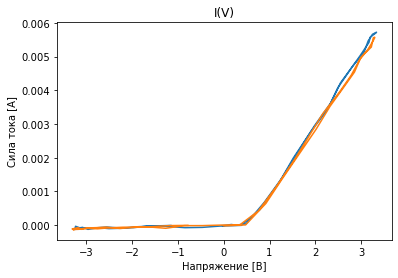

success: [71.78490042 67.16603681 38.69596447] -> [66.27921423 66.86656089 40.04684224] circuit DR_DR_R
success: [14.53910524 56.7161536  46.9035454 ] -> [12.78993101 59.34654142 54.42507075] circuit DR_DR_R
success: [62.99305335 27.17581909 33.24730153] -> [68.17601551 28.6111442  32.61663558] circuit DR_DR_R
success: [64.88145517 41.64693789 95.40709783] -> [73.48736716 49.31088553 79.12372211] circuit DR_DR_R
success: [56.33587752 99.8606502  46.27816472] -> [57.40770577 94.95380352 48.557832  ] circuit DR_DR_R
!!fail:  [56.76870506 10.7899827  43.51502641] -> [21.53703348  8.19357267] DR_DR_R detected like DR_DR
FAIL:


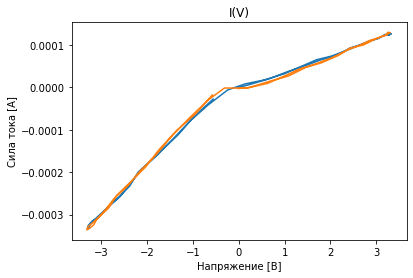

!!fail:  [ 5.21453349 14.01039519 93.12822492] -> [ 4.87685838 11.44538705] DR_DR_R detected like DR_DR
FAIL:


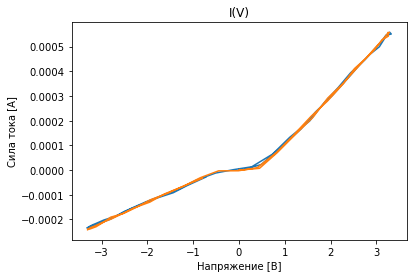

success: [52.20132301 28.5037788  68.93588621] -> [51.24163571 29.09136588 73.30245771] circuit DR_DR_R
success: [89.87563701 58.95121518 49.9847646 ] -> [85.81754401 57.66277226 52.22067455] circuit DR_DR_R
success: [34.65353579 74.45652622 26.54201856] -> [33.95978461 75.50429765 25.71333615] circuit DR_DR_R
!!fail:  [75.65233861 10.99776395 42.72047869] -> [23.34226458  8.19357267] DR_DR_R detected like DR_DR
FAIL:


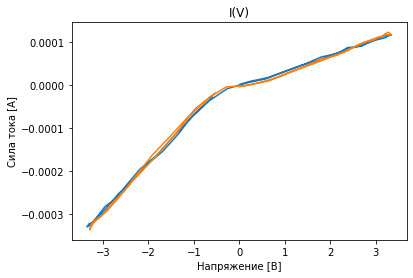

!!fail:  [37.8171684  16.51912528 45.90741162] -> [18.70693056 10.96383908] DR_DR_R detected like DR_DR
FAIL:


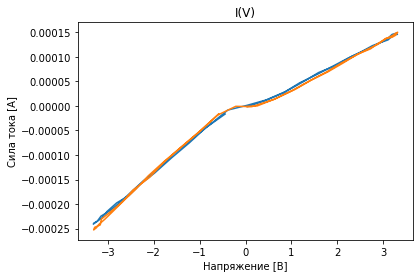

!!fail:  [64.6979185   1.2501507  76.13297848] -> [32.84396408  1.51714919] DR_DR_R detected like DR_DR
FAIL:


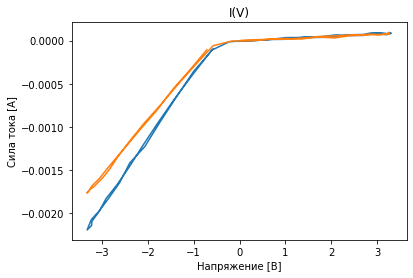

success: [35.86674833 62.00801917 66.84088769] -> [34.65884115 67.58551543 71.5486259 ] circuit DR_DR_R
!!fail:  [ 2.02993455 95.47125386 26.02301504] -> [16.55064573  1.75158831] DR_DR_R detected like DR_R
FAIL:


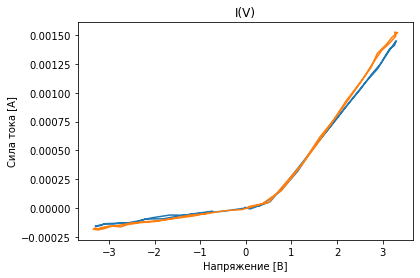

!!fail:  [59.42885715 99.25336503  7.79607235] -> 7.21990760044688 DR_DR_R detected like R
FAIL:


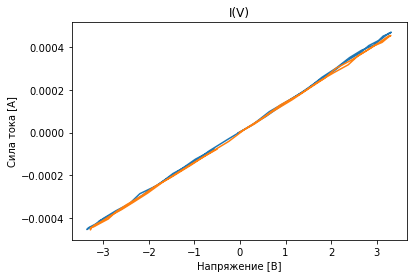

success: [86.65948855 81.25363065 93.93100885] -> [90.36375947 83.35916709 93.67601509] circuit DR_DR_R
!!fail:  [69.86989006 42.93790258 16.09073913] -> [13.37679577 12.3102242 ] DR_DR_R detected like R_C
success: [26.18202567 75.03000989 89.98358087] -> [27.84353006 76.65773727 82.80072771] circuit DR_DR_R
!!fail:  [88.17505636 39.55376068 24.2149427 ] -> [16.17053625 13.11664849] DR_DR_R detected like DR_DR
!!fail:  [78.47602131 63.52624349  7.37352518] -> [ 6.97253633 15.62987435] DR_DR_R detected like R_C
success: [96.46547862 46.93149481 53.15340938] -> [90.73066179 47.53790921 57.73668809] circuit DR_DR_R
!!fail:  [20.07117119 24.31572741 42.12564054] -> [ 6.79708478 12.70241404] DR_DR_R detected like DR_R
!!fail:  [40.06188974 21.8806864  94.41148693] -> [26.66678145 16.66980508] DR_DR_R detected like DR_DR
!!fail:  [39.19594325 27.27163166 92.48286708] -> [26.21716092 19.7902431 ] DR_DR_R detected like DR_DR
!!fail:  [ 9.11870855 35.23221703 93.41429302] -> [21.42035022  8.121

In [14]:
cre = CircuitPredictor()
cre.test_me()